# Yearly Air Quality of India

In this notebook I will perform cleaning, exploratory analysis and prediction on the dataset files. I will focus on per-state analytics and predictions.

<div><img src="IndiaStatesByRTOcodes.png" width="400"/></div>

## Import Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Load State Information

First we define the state and its appropriate code for reference as well as all the available metrics.

In [2]:
df_states = pd.read_csv('dataset/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [3]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

## Data Preprocessing

We are working with a large dataset which is split in multiple files (for each city in each state), collected through various different agencies.<br>
It is expected that each agency collected various metrics in different formats. In addition to this, agencies started collecting data<br>
in different dates. We should check for all these notes.

In [4]:
def combine_state_df(state_name, include_cities=False):
    '''
    Combine all state files into a single dataframe.

    Parameters
    ----------
        state_name (str):      The name of the state
        include_cities (bool): Adds a new column for the name of the city from each file

    Return
    ------
        df (DataFrame): The combined dataframe from all files of a specific state
    '''
    
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'dataset/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')

    if include_cities:
        combined_df = []
        for state_file in state_files:
            file_name = state_file.split('dataset\\')[1][0:-4]
            file_df = pd.read_csv(state_file)
            file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
            combined_df.append(file_df)
        return pd.concat(combined_df)
    else:
        return pd.concat(map(pd.read_csv, state_files))

Let's try to understand the properties of the dataset provided. I will take a closer look on the details of India's capital state, Delhi.

In [5]:
df = combine_state_df('Delhi')

Combining a total of 40 files...



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796171 entries, 0 to 20841
Data columns (total 59 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  O Xylene (ug/m3)     float64
 16  Temp (degree C)      float64
 17  RH (%)               float64
 18  WS (m/s)             float64
 19  WD (deg)             float64
 20  SR (W/mt2)           float64
 21  BP (mmHg)            float64
 22  VWS (m/s)            float64
 23  Xylene (ug/m3)       float64
 24  

From these dataframe details we can see this state's feature vector comprises 58 unique metrics with a total of 2796171 records!<br>
Let's also check what is the ratio of missing values for these features.

### Missing Values

In [7]:
df.isnull().sum().sort_values(ascending=False)

NMHC (ug/m3)           2796171
SPM (ug/m3)            2796171
Gust (km/hr)           2796171
Eth-Benzene ()         2796171
Variance (n)           2796171
Power (W)              2796171
CO2 (mg/m3)            2796171
Temp (ug/m3)           2796171
Gust (kl/h)            2796171
Gust (m/s)             2796171
CH4 ()                 2785343
MP-Xylene ()           2766966
HCHO (ug/m3)           2762343
Xylene ()              2761593
Hg (ug/m3)             2761020
MH (m)                 2758723
SO2 ()                 2756881
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
WD (degree C)          2752283
Ozone (ppb)            2748595
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
Benzene ()             2718736
Toluene ()             2717842
AT ()                  2713155
CO (ug/m3)             2712197
NOx (ug/m3)            2710085
WS ()                  2678359
WD ()                  2673708
O Xylene

Looks like we are dealing with a dataframe containing a high rate of missing values. On a closer look we can see that<br>
some of the feature columns are completely empty, so we can easily drop those. The rest we have to deal with eventually.

Another observation is that there are two features, `From Date` and `To Date`, which describe the time window of each<br>
metric collected. Since we are dealing with date-time data, it is common to make our index one of these columns. Therefore,<br>
I will transform this index column to datetime format instead of a panda's object.

Let's construct a function that takes care of the above observations.

In [8]:
def clean_df(df, rows_only=False):
    '''
    Cleans the DataFrame by initializing the index and remove empty columns and/or rows.

    Parameters
    ----------
        df (DataFrame):   The DataFrame to edit
        rows_only (bool): If enabled, drops columns filled with null values

    Return
    ------
        df (DataFrame): The cleaned dataframe
    '''
        
    # Make the 'From Date' column the index as datetime
    df.drop(columns='To Date', inplace=True)
    df['From Date'] = pd.to_datetime(df['From Date'])
    df.rename(columns={'From Date': 'datetime'}, inplace=True)
    df.set_index('datetime', inplace=True)

    # Drop all columns and rows that only contain missing values
    df.dropna(how='all', inplace=True)
    if not rows_only:
        df.dropna(how='all', axis='columns', inplace=True)
    return df

In [9]:
df = clean_df(df)

Below I create an enhanced function to see the percentages of missing values.

In [10]:
# Helper function that returs a DataFrame containing the number of null values and percentages for each column
def compare_nulls(df):
    null_vals = df.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percent Missing (%)': round(null_vals * 100 / len(df), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

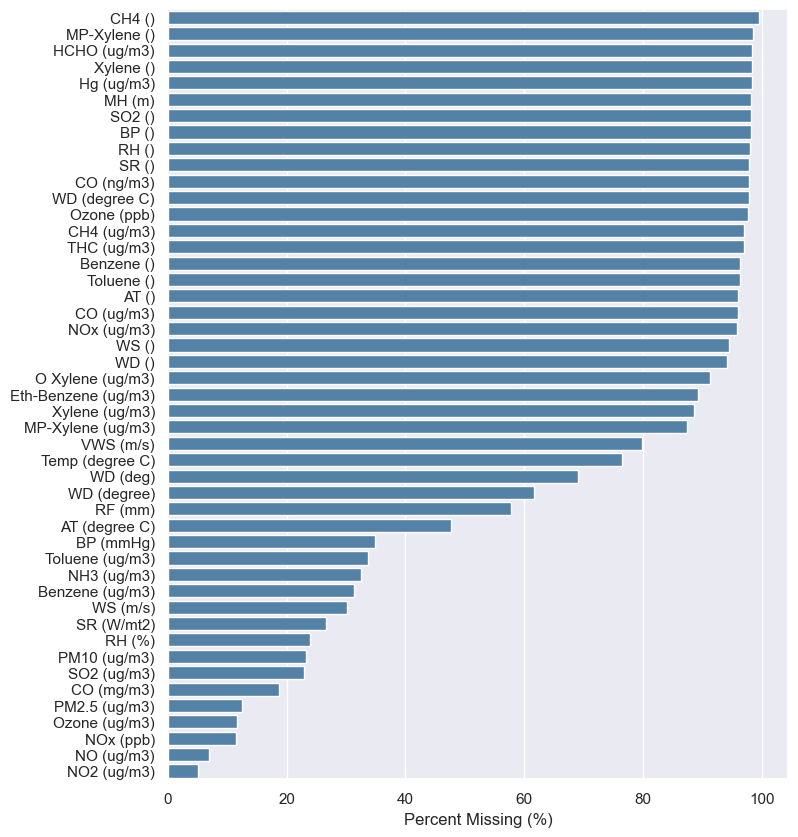

In [11]:
df_null_info = compare_nulls(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

The barplot shows that the majority of features contain very little information. However a first good observation is that some<br>
of these features seem pretty similar to others (i.e. `Xylene ()` and `Xylene (ug/m3)`). Later we will investigate this further.

### Null Investigation of the Complete Dataset

We investigate only one state. It is wise to get a feeling for the missing data of the complete dataset.

In [12]:
from IPython.display import clear_output

# Delete the previous dataframe to release some RAM space.
del df

features = {}
total_records = 0

for i, state_name in enumerate(unique_states):
    clear_output(wait=False)
    print(f"Processing state of {state_name} ({i+1}/{len(unique_states)})")
    df = combine_state_df(state_name)
    df = clean_df(df, rows_only=True)
    comparisons = compare_nulls(df)
    
    total_records += df.shape[0]

    for feature in comparisons.index:
        if feature in features:
            features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
        else:
            features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

Processing state of West Bengal (31/31)
Combining a total of 14 files...



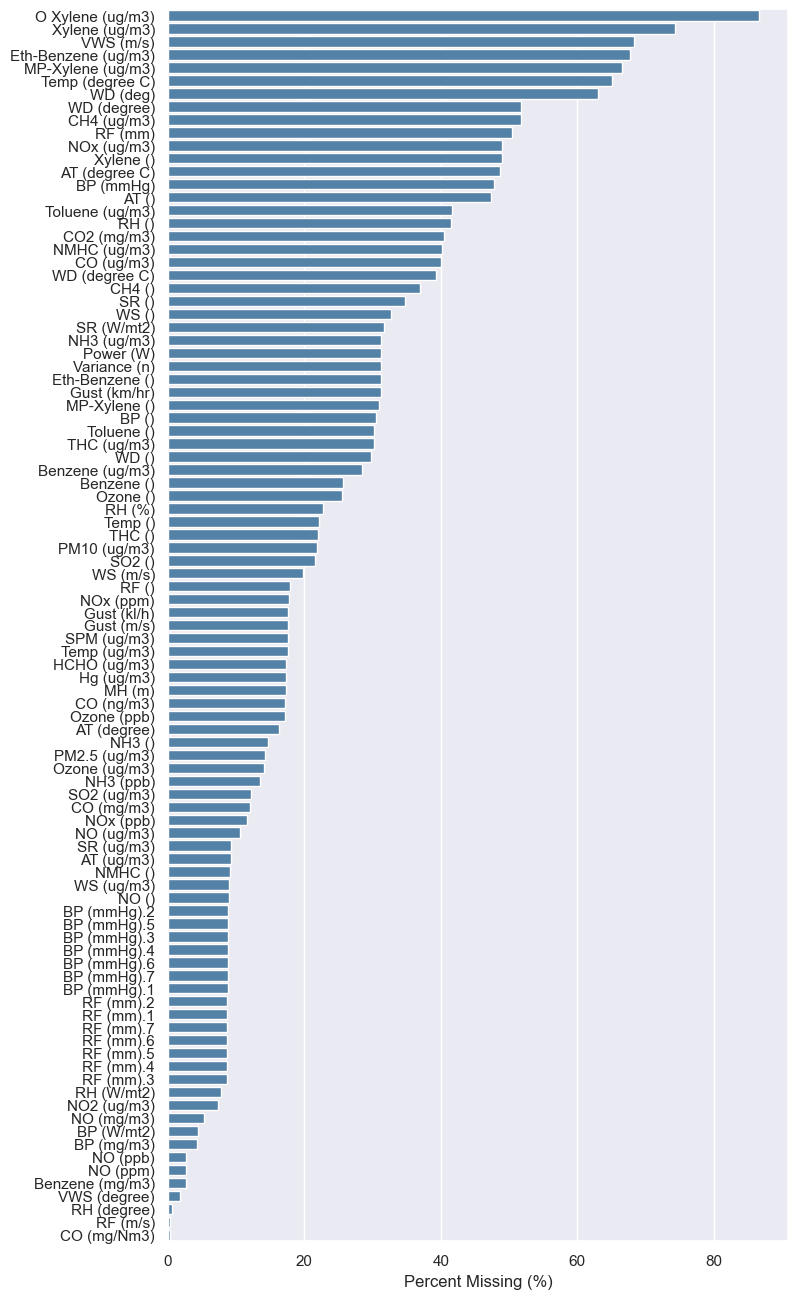

In [13]:
df_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
df_null_info['Percent Missing (%)'] = round(df_null_info['Null Count'] * 100 / total_records, 2)
df_null_info = df_null_info.sort_values(by=['Null Count'], ascending=False)

plt.figure(figsize=(8, 16))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

From this barplot and the previous of a single state, We can conclude that the various states collected different kinds and amounts of metrics.<br>
Typically with datasets like these, people tend keep features that contain less than 25-30% missing values, unless they contain important information.

Next, I will try to identify potential similarities between features, in order to further combine or eliminate features with no importance.

### Deeper Analysis - Feature Similarities

At this point, I decided to make a deeper analysis to explore similatiries in the various features. For instance thecolumns `Xylene ()` and `Xylene (ug/m3)`<br>
might contain similar metrics. Let's start by loading back and cleaning the capital state's dataframe.

In [14]:
df = combine_state_df('Delhi', include_cities=True)
df = clean_df(df)

Combining a total of 40 files...



In [15]:
# Helper function to plot groups of data ito subplots
def plot_groups(dataframe, feature_groups, figsize=(12,4)):
    fig, axes = plt.subplots(1, len(feature_groups), figsize=figsize)
    fig.suptitle('Group Similarities')
    for pos, group in enumerate(feature_groups):
        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[pos])
        axes[pos].set_title(group)
    plt.plot()

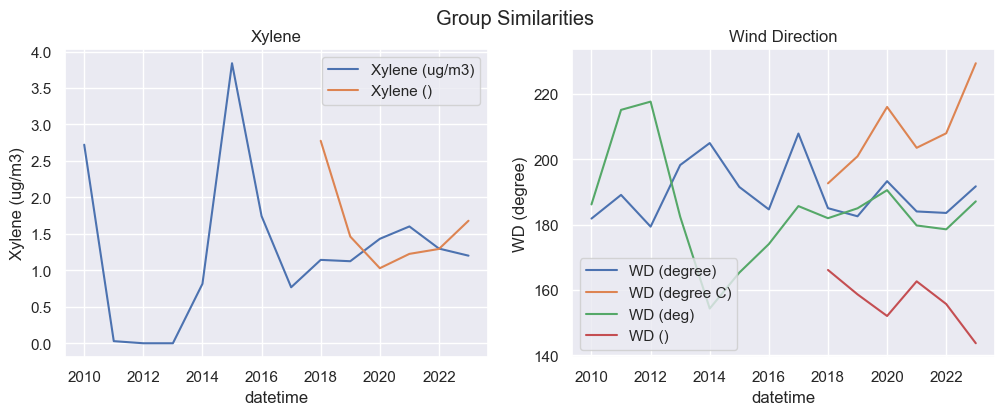

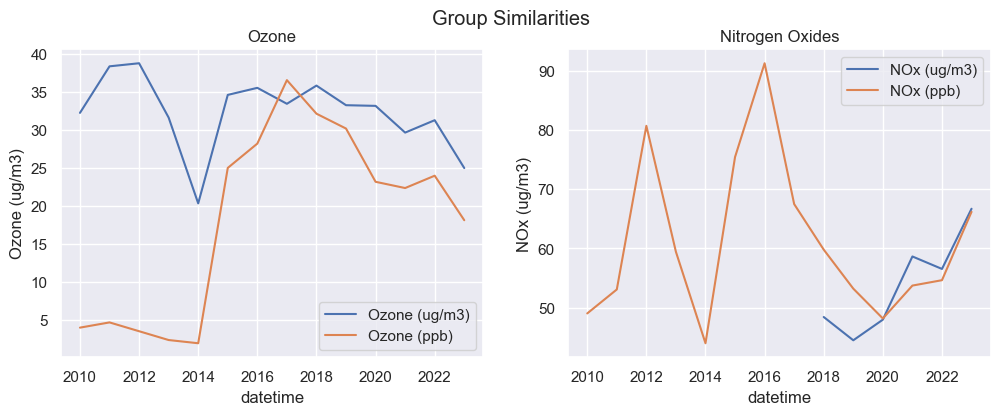

In [16]:
group1 = {
    'Xylene':          ['Xylene (ug/m3)', 'Xylene ()'],
    'Wind Direction':  ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"]
}

group2 = {
    'Ozone':           ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides': ['NOx (ug/m3)', 'NOx (ppb)']
}

plot_groups(df, group1)
plot_groups(df, group2)

It seems like some of the features are capturing the same metric units as others. This is a good indication and we can double confirm by using the pands describe.

In [17]:
all_groups = group1['Xylene'] + group1['Wind Direction'] + group2['Ozone'] + group2['Nitrogen Oxides']
df[all_groups].describe().applymap(lambda x: f"{x:0.3f}")

,Xylene (ug/m3),Xylene (),WD (degree),WD (degree C),WD (deg),WD (),Ozone (ug/m3),Ozone (ppb),NOx (ug/m3),NOx (ppb)
count,242944.000,34578.000,813361.000,43888.000,655812.000,122463.000,1874697.000,47576.000,86086.000,1876466.000
mean,1.337,1.319,186.417,205.871,184.905,157.480,32.370,25.864,52.076,56.894
std,5.762,3.348,94.905,88.418,80.286,91.992,34.778,19.535,59.768,70.730
min,0.000,0.000,0.020,1.200,0.030,1.300,0.010,0.050,0.100,0.000
25%,0.000,0.000,104.850,119.570,121.010,86.950,8.550,13.530,17.380,16.980
50%,0.000,0.400,187.380,230.435,185.310,147.830,19.600,20.480,31.050,31.680
75%,1.010,1.400,268.950,285.550,252.050,229.700,43.150,33.130,61.100,64.280
max,476.310,231.000,360.000,356.520,359.590,359.700,200.000,198.470,498.850,500.000


As it seems I was able to merge the following features. The rest have too many missing values so we are going to drop them.

#### Feature Merging

In [18]:
transfer_metrics = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [19]:
def fill_column(df, column, cols_to_integrate):
    '''
    Merges column records into a single column.

        Parameters
    ----------
        df (DataFrame):                The DataFrame to edit
        column (str):                  The name of the column to merge records into
        cols_to_integrate (list[str]): A list of column names to retrieve records
    '''
    # Check if the original column exist, otherwise create it
    if column not in df.columns and any(name in df.columns for name in cols_to_integrate):
        df[column] = np.nan

    for col_name in cols_to_integrate:
        if col_name in df.columns:
            df[column] = df[column].fillna(df[col_name])
            df.drop(columns=[col_name], inplace=True)

In [20]:
for col, col_to_integrate in transfer_metrics.items():
    fill_column(df, col, col_to_integrate)

#### Threshold for Missing Values

From here we can drop the columns which contain a certain thrueshold (i.e 60%) of missing values.

In [21]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df.dropna(thresh=df.shape[0]*threshold, axis=1, inplace=True)

In [22]:
compare_nulls(df)

,Null Count,Percent Missing (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),873898,31.25
NOx (ug/m3),833619,29.81
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


## Exploratory Data Analysis (EDA)

I am collecting the metrics (features) into several groups. This will enable better comparisons.

In [23]:
pollutants = {
    # A mixture of solid particles and liquid droplets found in the air.
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    # Nitrogen gases form when fuel is burned at high temperatures.
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    # These are found in coal tar, crude petroleum, paint, vehicle exhausts and industrial emissions.
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    # Released from the partial combustion of carbon-containing compounds.
    'Carbon Monoxide': ['CO (mg/m3)'],

    # Released naturally by volcanic activity and is produced as a by-product of copper extraction and the burning of sulfur-bearing fossil fuels.
    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    # It is created mostly the combustion of fossil fuels.
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    # Affects Earth's average temperatures
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}


### Visualizations

Let's start by grouping our DataFrame by various frequencies.

In [24]:
df_slice_by_day   = df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True)
df_slice_by_month = df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True)
#df_slice_by_year = df.groupby([df.index.year]).mean(numeric_only=True)

Check how many missing values we get after we average our results.

In [25]:
df_slice_by_day.isnull().sum().sort_values(ascending=False)

PM2.5 (ug/m3)    99
NO (ug/m3)        0
NO2 (ug/m3)       0
CO (mg/m3)        0
Ozone (ug/m3)     0
NOx (ug/m3)       0
dtype: int64

In [26]:
df_slice_by_day.loc[df_slice_by_day.isnull().any(axis=1)].index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14', '2010-01-15', '2010-01-16',
               '2010-01-17', '2010-01-18', '2010-01-19', '2010-01-20',
               '2010-01-21', '2010-01-22', '2010-01-23', '2010-01-24',
               '2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28',
               '2010-01-29', '2010-01-30', '2010-01-31', '2010-02-01',
               '2010-02-02', '2010-02-03', '2010-02-04', '2010-02-05',
               '2010-02-06', '2010-02-07', '2010-02-08', '2010-02-09',
               '2010-02-10', '2010-02-11', '2010-02-12', '2010-02-13',
               '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-20',
               '2010-02-21', '2010-02-22', '2010-02-23', '2010-02-24',
               '2010-02-25', '2010-02-26', '2010-02-27', '2010-02-28',
      

We can see that all of the missing data come from the early days of the collections.

#### Grouping Data

Next, we visualize the data to better make comparisons.

In [27]:
def plot_metrics(metrics, dashes=False):
    for metric, values in metrics.items():
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        fig.tight_layout(pad=4.0)
        fig.suptitle(metric)

        for i, (group, df) in enumerate(values.items()):
            ax = sns.lineplot(data=df, ax=axes[i], dashes=dashes)
            ax.set_title(group)
            plt.plot()

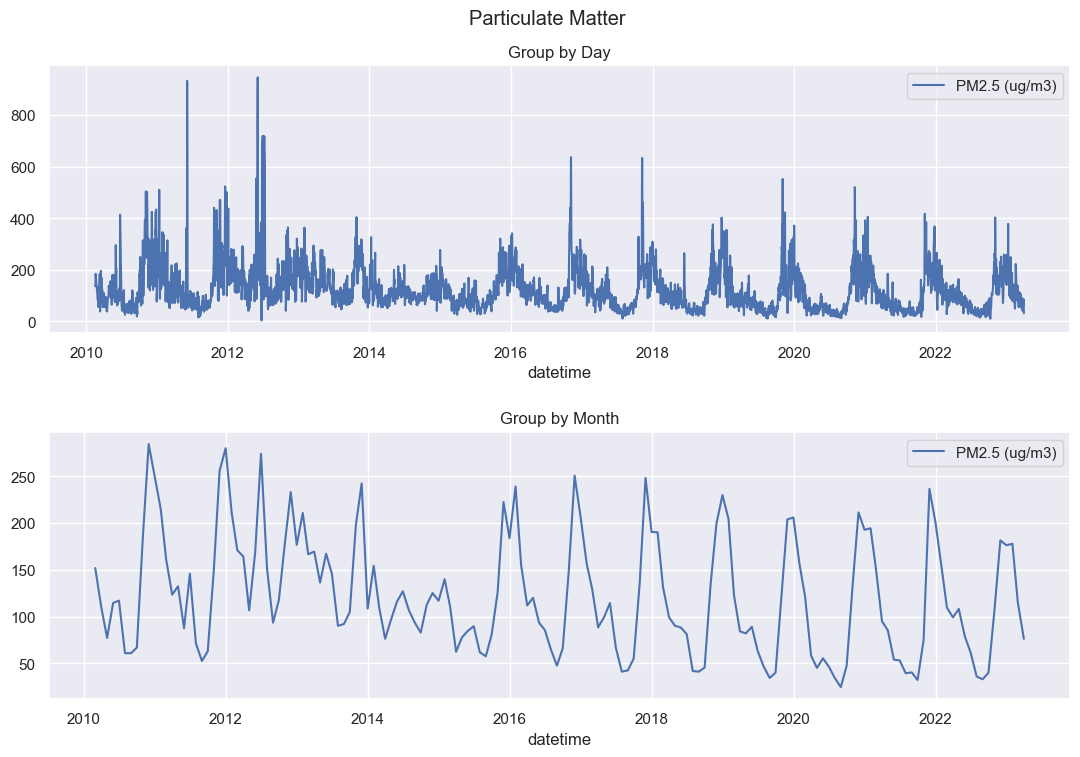

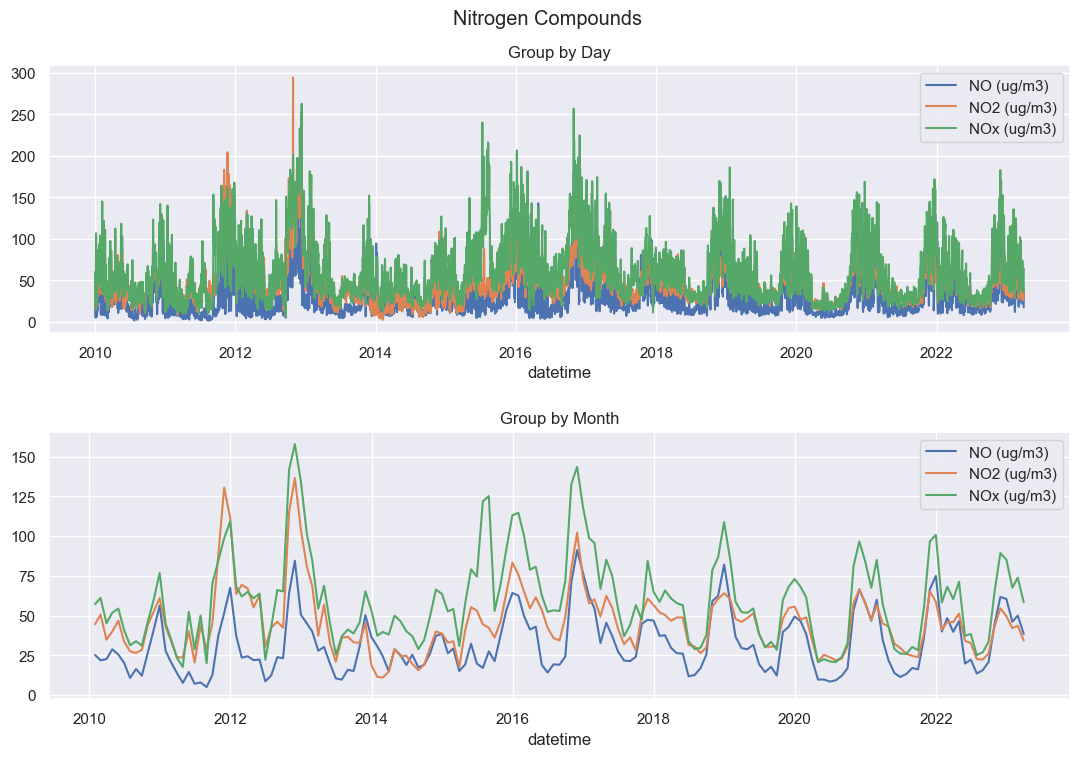

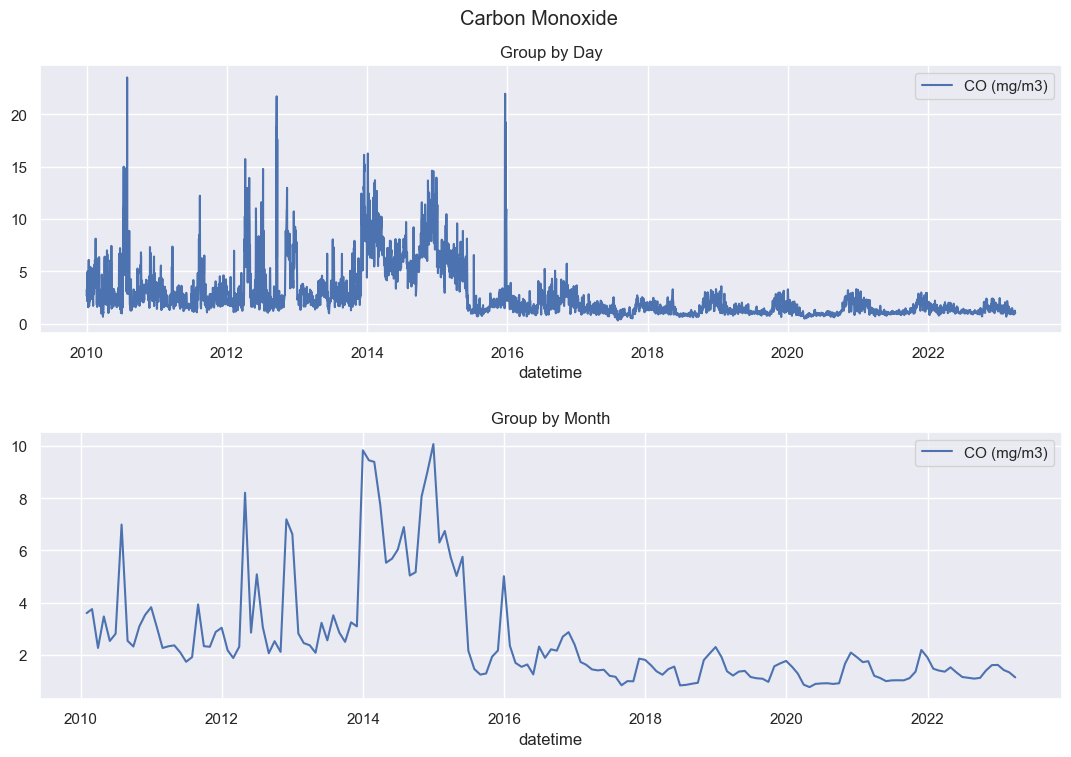

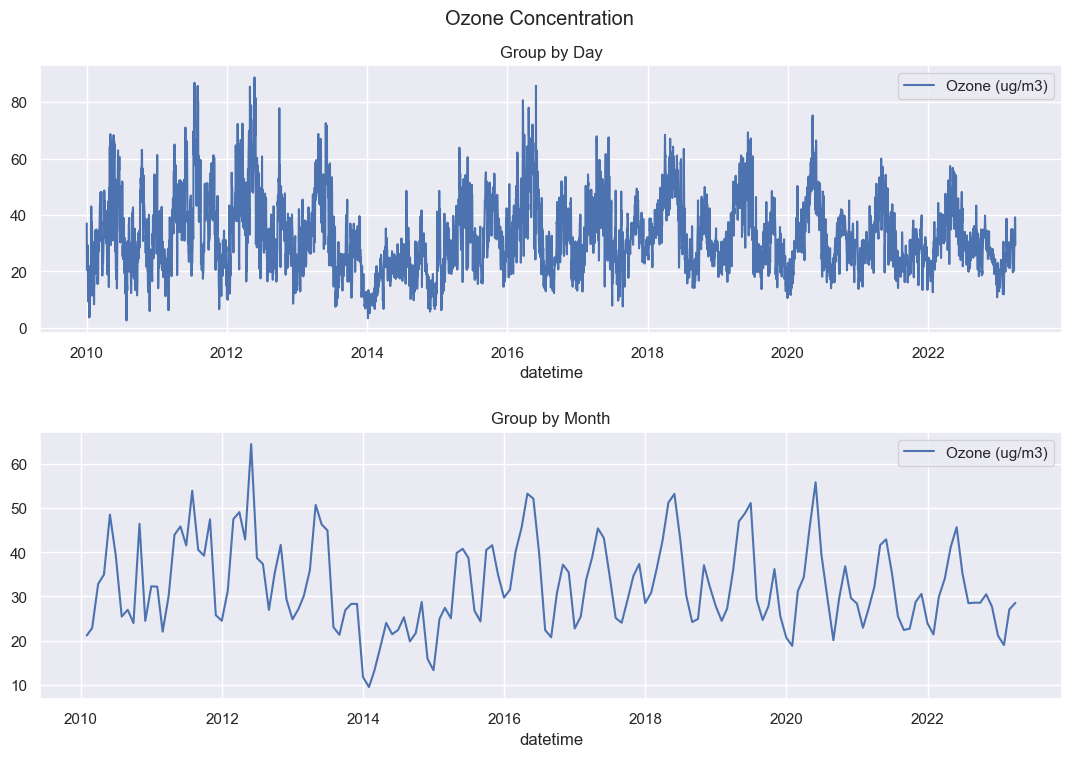

In [28]:
slices = {
    'Particulate Matter': {
        'Group by Day':   df_slice_by_day[df_slice_by_day.columns.intersection(pollutants['Particulate Matter'])],
        'Group by Month': df_slice_by_month[df_slice_by_month.columns.intersection(pollutants['Particulate Matter'])]
    },

    'Nitrogen Compounds': {
        'Group by Day':   df_slice_by_day[df_slice_by_day.columns.intersection(pollutants['Nitrogen Compounds'])],
        'Group by Month': df_slice_by_month[df_slice_by_month.columns.intersection(pollutants['Nitrogen Compounds'])]
    },

    'Carbon Monoxide': {
        'Group by Day':   df_slice_by_day[df_slice_by_day.columns.intersection(pollutants['Carbon Monoxide'])],
        'Group by Month': df_slice_by_month[df_slice_by_month.columns.intersection(pollutants['Carbon Monoxide'])]
    },

    'Ozone Concentration': {
        'Group by Day':   df_slice_by_day[df_slice_by_day.columns.intersection(pollutants['Ozone Concentration'])],
        'Group by Month': df_slice_by_month[df_slice_by_month.columns.intersection(pollutants['Ozone Concentration'])]
    }
}

plot_metrics(slices)

#### Year Slices

It looks like we are dealing with seasonal patterns on the metrics we selected. Let's dive a little bit deeper and try to understand<br>
what's happening per season on a yearly basis. For example let's consider a slice of the data, such as the year 2019-2020.

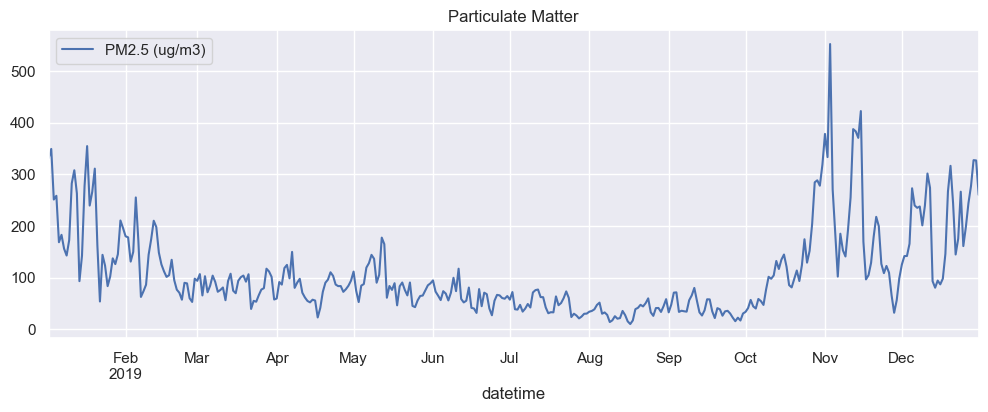

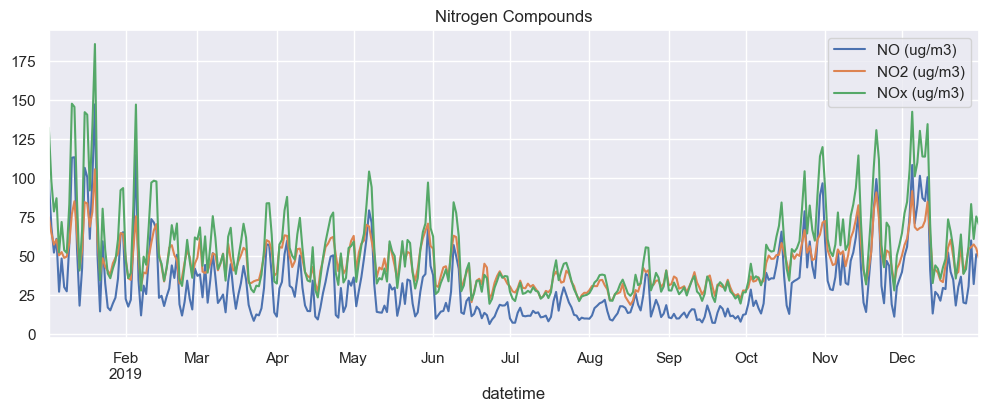

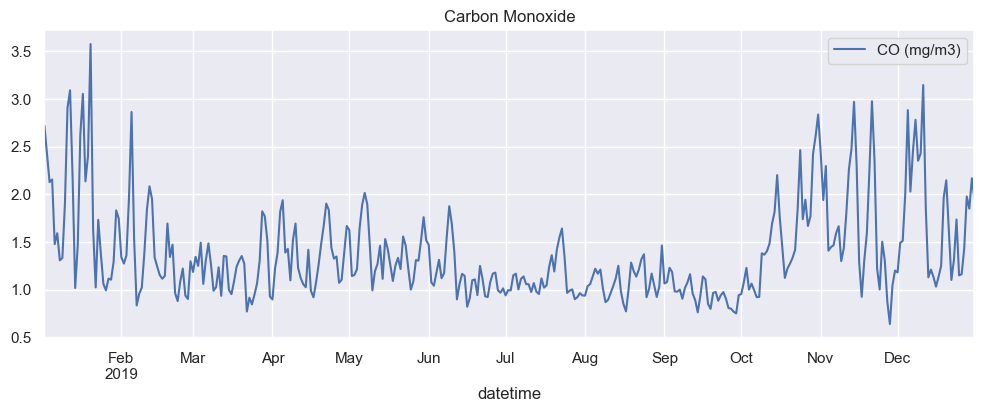

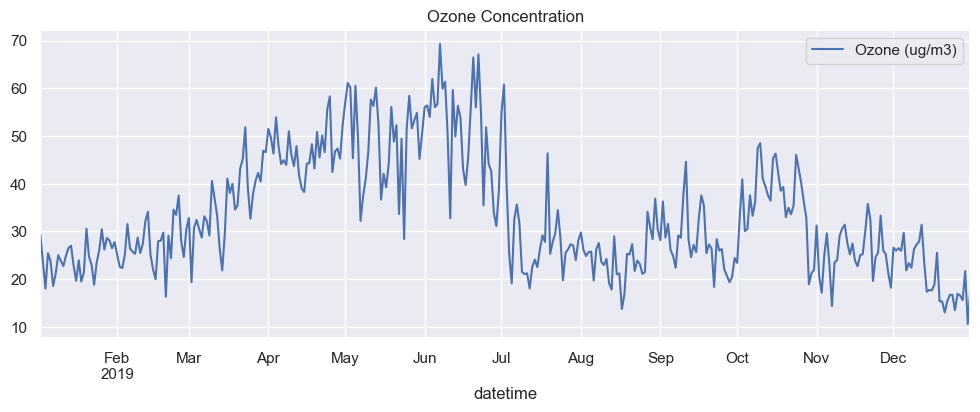

In [29]:
for slice, df in slices.items():
    df['Group by Day'].query('datetime > 2019 and datetime < 2020').plot(title=slice, figsize=(12,4))

Here we can see that the values for the `Particulate Mater`, `Nitrogen Compounds` and `Carbon Monoxide`, start to increase around October<br>
and last until approxamatelly March. For the `Ozone Concentration` metric we see an opposite result, where the maximum values in a year<br>
are around mid May/June.

We can see a better explanation on the relationships between the variables, as well as the distribution of each one through a pair plot.

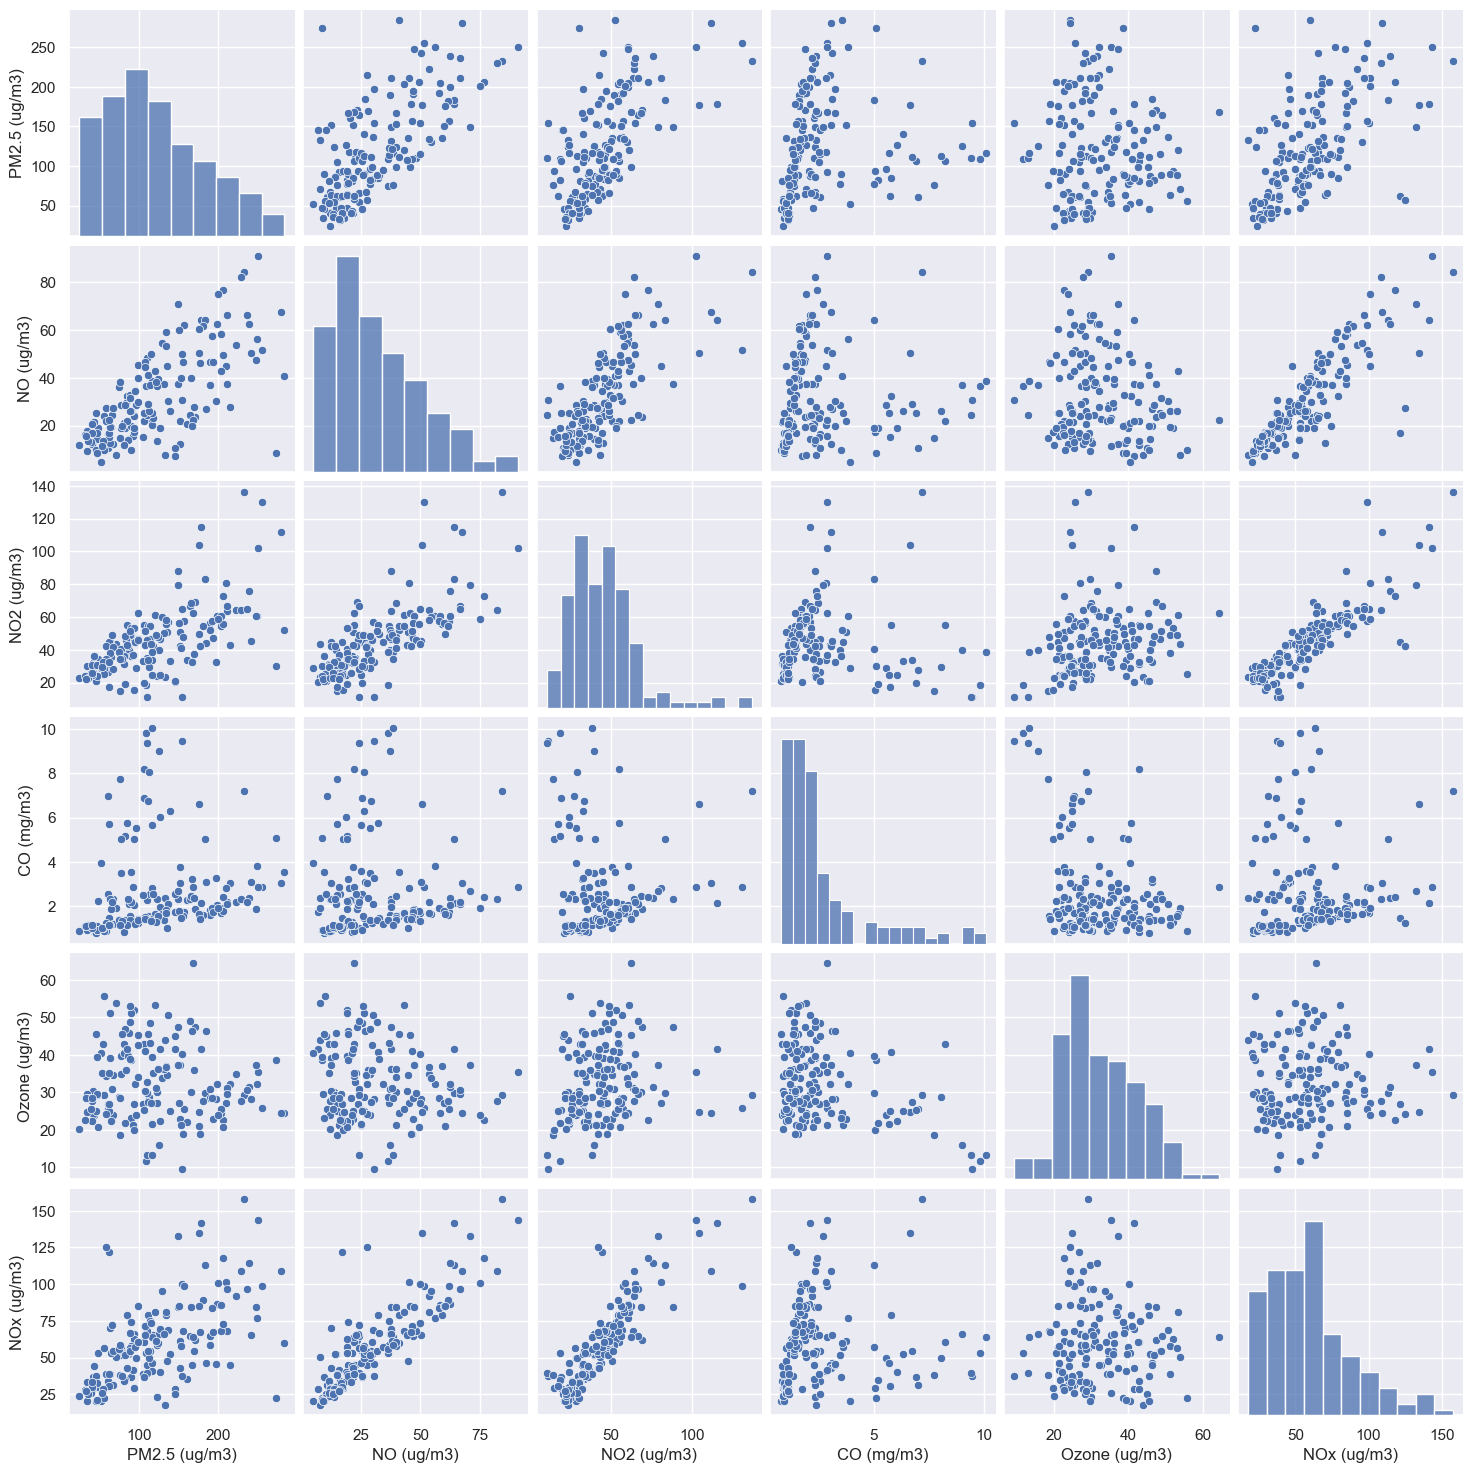

In [30]:
sns.pairplot(df_slice_by_month)

### Correlation Matrix

Through a correlation matrix, we can easily visuallize the correlation degree between the variables.

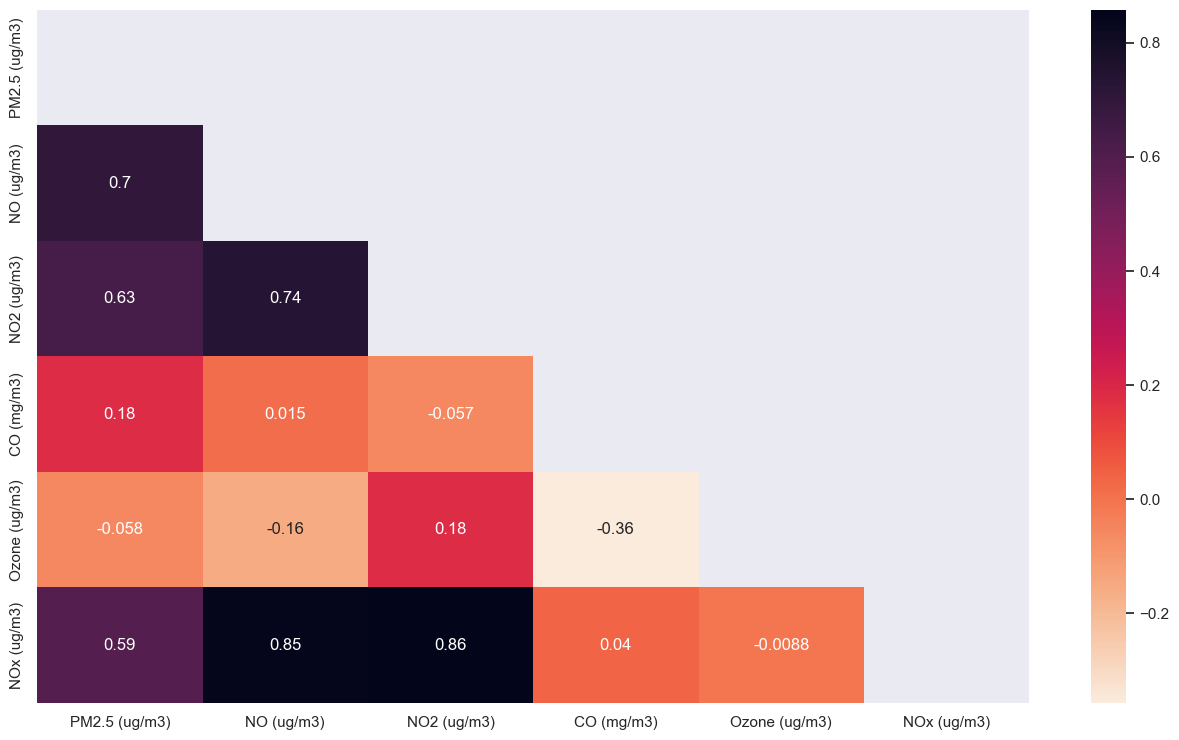

In [31]:
corr = df_slice_by_month.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,9))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

This plot shows us various high correlated features. For example:

- `NOx` is strongly correlated with the features `NO`and `NO2`.
- `NO2` is strongly correlated with `NO`
- The particle accumulation feature `PM2.5` increases as the values of `NO` increase.

We would probably say here that it is fairly normal for the values of the *Nitrogen Compounds* to be correlated, as they represent the same group.

Next I will try to do forecasting, based on the analysis.

To be continued...